# <font color='red'>Basic Analytics Applied to Training Set of Heroes of the Storm Game Data</font>

## A brief overview of the game

Matches are played between two teams of five players on any one of a number of maps.

Each player selects a playable character ('Hero') to control for the duration of the match.

The 'class' of a Hero corresponds to a general role in the match with associated traits, strengths and weaknesses. For example, Assassins deal high damage but are vulnerable; Warriors deal low damage but are durable. The objective of the game is to destroy a special structure belonging to the opposing team.

The following diagram illustrates a breakdown of the character classes, where the lowest tier represents the names of individual characters:

<img src="HOTSFlow.png">

### 1. Determine the most played heroes in each category:
* Support
* Assassin
* Warrior
* Specialist

### 2. Identify the various team compositions played

### 3. Study the effect of team rating on the outcome of a match.

### 4. Does team composition affect the outcome of a match?

# Data Gathering

Data was collected from http://www.hotslogs.com/Default, a site containing large amounts of historical data on games played.
- Data was readily available in CSV format
- CSV files were available for individual player records, as well as per game records, and also information on the maps
- Different data was stored in each CSV file

Our first step is to load each CSV file into a pandas dataframe

In [1]:
#import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Allow plots to be displayed in notebook
%matplotlib inline

#using files to format dataframe display
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#load both csv files into tow respective dataframes
DF_Replay = pd.read_csv("TSReplay.csv")

DF_Characters = pd.read_csv("TSCharacters.csv")

DF_Map_Groups = pd.read_csv("HeroAndMap.csv")

In [2]:
DF_Replay.head(2)

,ReplayID,GameMode(3=Quick Match 4=Hero League 5=Team League),Map,Replay Length,Timestamp (UTC)
0,23915730,4,Haunted Mines,00:12:00,5/14/2015 12:55:26 AM
1,23927005,3,Cursed Hollow,00:21:00,5/14/2015 12:55:26 AM


# Data Cleaning
The first step is to remove games that are not from the competitive game mode.
In our initial datasets, the "GameMode" feature describes the particular type of game that was played.
The number 4 corresponds to the data we are interested in, so we select only rows with that value

### Using data from only the competitive mode is useful for two reasons:

1. Reduces the size of the dataset to a more manageable, laptop-friendly number
2. Ensures that only one of each hero can be present in a single game

One of the most challenging aspects of our project was extracting a good representation of "Team Composition" from our datasets.
We achieved this as follows:
- Using the "Group" feature from our individual player data, indicating which character class the chosen character belongs to
- Combining this with the "IsWinner" feature to separate our players into 2 groups of 5 for every game
- Recording the combination of character classes that the winning team played
- Recording the combination of character classes that the losing team played

In [3]:
# Rename columns in the dataframe
DF_Replay.columns = ['ReplayID', 'GameMode', 'Map', 'ReplayLength', 'Timestamp']
# Only keep rows related to competitive gameplay (4 = Hero League)
DF_Replay = DF_Replay[DF_Replay['GameMode'] == 4]
DF_Replay.head(10)

,ReplayID,GameMode,Map,ReplayLength,Timestamp
0,23915730,4,Haunted Mines,00:12:00,5/14/2015 12:55:26 AM
2,23915740,4,Garden of Terror,00:26:18,5/14/2015 12:55:27 AM
10,23924385,4,Garden of Terror,00:34:37,5/14/2015 12:55:39 AM
22,23915858,4,Sky Temple,00:22:32,5/14/2015 12:56:00 AM
23,23915915,4,Dragon Shire,00:24:00,5/14/2015 12:56:01 AM
25,24393574,4,Garden of Terror,00:20:15,5/14/2015 12:56:08 AM
30,23929877,4,Dragon Shire,00:22:01,5/14/2015 12:56:13 AM
31,23950711,4,Blackheart's Bay,00:16:45,5/14/2015 12:56:13 AM
32,24507009,4,Garden of Terror,00:30:30,5/14/2015 12:56:14 AM
34,23915821,4,Blackheart's Bay,00:24:20,5/14/2015 12:56:15 AM


## Converting "ReplayLength" to seconds
- The value of this feature is in the HH:MM:SS format.
- To make numerical analysis simpler, we convert all of these values to seconds as follows:

In [4]:
#Split the string for ReplayLength into several sub-cells based on the ':'
# XX : YY : ZZ
# X *60 *60 (for float(sec))
# Y *1 *60  (for float(sec))
# Z *1      (for float(sec))

#from format   |  hh:mm:mm  |
#to format     |  hh  |  :  | mm:ss  |
ChangeTime = DF_Replay['ReplayLength'].str.partition(':')
ChangeTime.columns = ['Hour', 'Col2', 'MinSec']
#Now we have one column for hours, and one for both minutes and seconds to partition again

#from format  |  mm:ss  |
#to format    |  mm  |  :  |  ss  |
ChangeTime2 = ChangeTime['MinSec'].str.partition(':')
ChangeTime2.columns = ['Min', 'Space', 'Second']
#now we have one column for minutes and one for seconds

#Get both column in float type
ChangeTime2['Min'] = ChangeTime2['Min'].astype(float)
ChangeTime2['Second'] = ChangeTime2['Second'].astype(float)

#Apply math to convert min to sec, then add minutes and seconds together
ChangeTime2['Min']= ChangeTime2['Min'] * 60
ChangeTime2['Second'] = ChangeTime2['Min'] + ChangeTime2['Second']
ChangeTime2 = ChangeTime2[[2]]

ChangeTime = ChangeTime.drop('MinSec', axis=1)
ChangeTime['Hour'] = ChangeTime['Hour'].astype(float)
#change the values in the column with *60 to get in minutes, and *60 again to get result in seconds
ChangeTime['Hour'] = ChangeTime['Hour'] * 60 * 60     

ChangeTime['Col2'] = (ChangeTime2['Second'] + ChangeTime['Hour'])

DF_Replay['ReplayLength'] = ChangeTime['Col2']
DF_Replay.head()

,ReplayID,GameMode,Map,ReplayLength,Timestamp
0,23915730,4,Haunted Mines,720.0,5/14/2015 12:55:26 AM
2,23915740,4,Garden of Terror,1578.0,5/14/2015 12:55:27 AM
10,23924385,4,Garden of Terror,2077.0,5/14/2015 12:55:39 AM
22,23915858,4,Sky Temple,1352.0,5/14/2015 12:56:00 AM
23,23915915,4,Dragon Shire,1440.0,5/14/2015 12:56:01 AM


## A point of definition:
MMR stands for 'Matchmaking Rating'. This is a numeric value which approximates the skill level of a player according to their career wins and losses.

### Note:
The "MMR Before" feature simply indicates that the rating of the player was recorded as the game begins, rather than once it is completed. Since we are concerned with five-player teams rather than the performance of individual players, we will average this value when comparing compositions.

The terms "Rating" and "MMR" may be used interchangeably during the course of this notebook

In [5]:
DF_Characters.head()

,ReplayID,Is Auto Select,Hero,Hero Level,Is Winner,MMR Before
0,23915730,False,Rehgar,14,False,3170.0
1,23915730,False,Falstad,10,False,3330.0
2,23915730,False,Jaina,7,True,3442.0
3,23915730,False,Sylvanas,13,False,2666.0
4,23915730,False,Zagara,10,True,3198.0


In [6]:
DF_Map_Groups.head(2)

,ID,Name,Group,SubGroup
0,0,Unknown,NaN,NaN
1,1,Abathur,Specialist,Utility


In [7]:
#Remove all after row 49, to remove map IDs and keep all data for Heroes
DF_Map_Groups = DF_Map_Groups[:48]

#DF3 = DF.drop('ID', axis=1).drop('SubGroup', axis=1)
DF_Map_Groups = DF_Map_Groups.drop('SubGroup', axis=1).drop('ID', axis=1)

#Returning last 3 elements to check
DF_Map_Groups.iloc[45:]

,Name,Group
45,Gall,Assassin
46,Lunara,Assassin
47,Greymane,Assassin


## Merging
We now have 2 dataframes with a "ReplayID" feature.

For each occurrence of this feature in the DF_Replay dataframe (one entry per game), there are 10 rows with that ID in the DF_Characters dataframe (10 players in each game).

So we can merge on this feature

In [8]:
#Need to merge on 'ReplayID' and duplicate entries
from pandas import merge
DF1 = pd.merge(DF_Replay, DF_Characters, left_on=["ReplayID"], right_on=['ReplayID'], how='left')
DF1.head(4)

#deleting previous dataframes created for memory reasons
del DF_Replay
del DF_Characters

In [9]:
#Need to merge on 'Name' 
DF = pd.merge(DF1, DF_Map_Groups, left_on=["Hero"], right_on=["Name"], how='left')

#delete the former dataframe DF_Map_Groups for memory's optimization
del DF_Map_Groups
del DF1

In [10]:
#Saving the merged Dataframe to a csv file
DF.to_csv("HeroLeagueData.csv")

In [11]:
DataFrame = pd.read_csv("HeroLeagueData.csv")
del DF
DataFrame.head()

,Unnamed: 0,ReplayID,GameMode,Map,ReplayLength,Timestamp,Is Auto Select,Hero,Hero Level,Is Winner,MMR Before,Name,Group
0,0,23915730,4,Haunted Mines,720.0,5/14/2015 12:55:26 AM,False,Rehgar,14,False,3170.0,Rehgar,Support
1,1,23915730,4,Haunted Mines,720.0,5/14/2015 12:55:26 AM,False,Falstad,10,False,3330.0,Falstad,Assassin
2,2,23915730,4,Haunted Mines,720.0,5/14/2015 12:55:26 AM,False,Jaina,7,True,3442.0,Jaina,Assassin
3,3,23915730,4,Haunted Mines,720.0,5/14/2015 12:55:26 AM,False,Sylvanas,13,False,2666.0,Sylvanas,Specialist
4,4,23915730,4,Haunted Mines,720.0,5/14/2015 12:55:26 AM,False,Zagara,10,True,3198.0,Zagara,Specialist


We have now removed all entries for games that were not played in the competitive mode using the "GameMode" feature and so we can drop this as it is no longer needed. Additionally, "Timestamp" and "Is Auto Select" can be dropped as they are not relevant.

We also rename the columns to remove spaces so they are easer to use.

In [12]:
#drop these columns from dataframe as they are no longer relevant
DataFrame = DataFrame.drop('Unnamed: 0', axis=1).drop('GameMode', axis=1).drop('Name', axis=1).drop('Is Auto Select', axis=1).drop('Timestamp', axis=1)


#Overwrite the DataFrame's Column names to get it into correct format for future use
DataFrame.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group']
#similar to:
#DF = DF.rename(columns = ('Replay Length':'ReplayLength'))
#DF = DF.rename(columns = {'Timestamp (UTC)':'Timestamp'})
#DF = DF.rename(columns = {'Is Auto Select':'AutoSelect'})
#...

list(DataFrame.columns.values)

['ReplayID',
 'Map',
 'ReplayLength',
 'Hero',
 'HeroLevel',
 'IsWinner',
 'MMRbefore',
 'Group']

In [13]:
DataFrame.dtypes

ReplayID          int64
Map              object
ReplayLength    float64
Hero             object
HeroLevel         int64
IsWinner           bool
MMRbefore       float64
Group            object
dtype: object

## More data cleaning - Null values
We check our cleaned data for null values.  There are null values present for the "MMRbefore" feature.

This is likely due to the fact that the data we have contains entries from the early release stages of the game, where this statistic may not have been tracked.

As we will be using this later in the notebook, these rows are not useful to us and can be dropped.

In [14]:
# Check if any fields contain null values
DataFrame.isnull().sum()

ReplayID             0
Map                  0
ReplayLength         0
Hero                 0
HeroLevel            0
IsWinner             0
MMRbefore       175460
Group                0
dtype: int64

In [15]:
# Remove all of the rows where the value of "MMRbefore" is not a finite number
DataFrame = DataFrame[np.isfinite(DataFrame["MMRbefore"])]

In [16]:
# Get the number of rows that have a unique value for "ReplayID"
# This value should be one tenth the value of the dataframe length, as each game has 10 players
A = DataFrame.ReplayID.nunique()
B = len(DataFrame)
print(A*10 == B)

True


In [17]:
# Find the number of entries remaining
DataFrame.shape

(1697780, 8)

# Data Understanding

In [18]:
numeric = DataFrame.select_dtypes(['int64','float64']).columns
numeric = numeric.drop("ReplayID")
DataFrame[numeric].head(5)

,ReplayLength,HeroLevel,MMRbefore
0,720.0,14,3170.0
1,720.0,10,3330.0
2,720.0,7,3442.0
3,720.0,13,2666.0
4,720.0,10,3198.0


In [19]:
DataFrame[numeric].corr()

,ReplayLength,HeroLevel,MMRbefore
ReplayLength,1.000000,-0.003705,-0.050528
HeroLevel,-0.003705,1.000000,0.103924
MMRbefore,-0.050528,0.103924,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FE85FF2B70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001FE84E607B8>]], dtype=object)

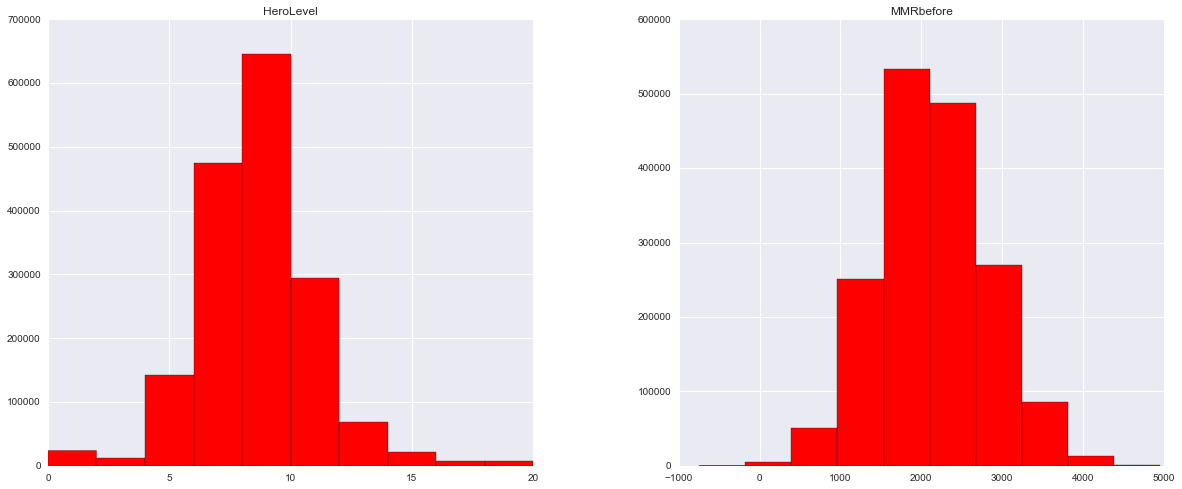

In [20]:
%matplotlib inline
DataFrame[["HeroLevel","MMRbefore"]].hist(figsize=(20, 8), color='red')
#plt.savefig("Histogram-Numeric-Features_HOTS.png")

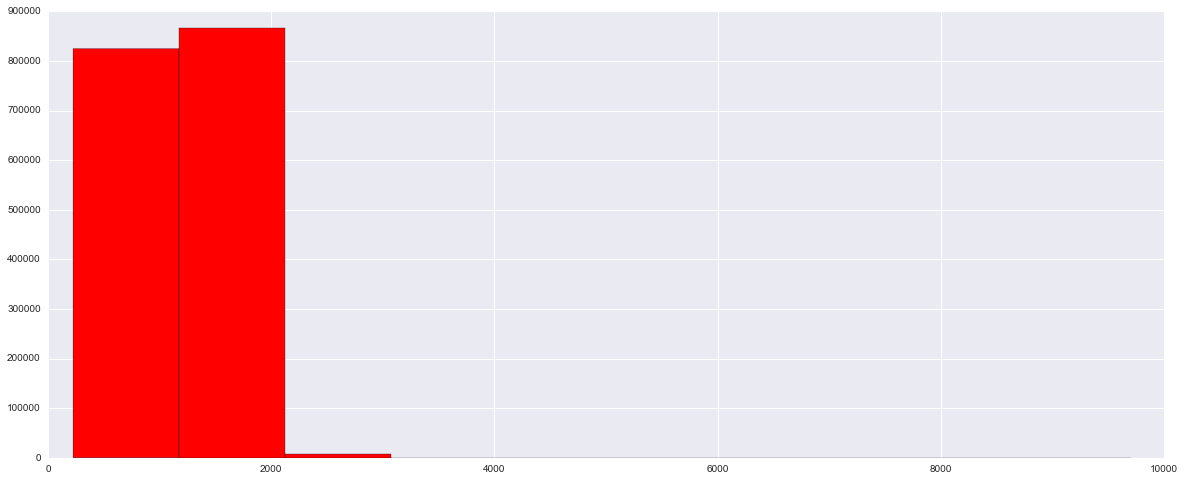

In [21]:
DataFrame["ReplayLength"].hist(figsize=(20, 8), color='red')

Removing outliers above a threshold of 3000 seconds gives a better representation of the spread of game duration

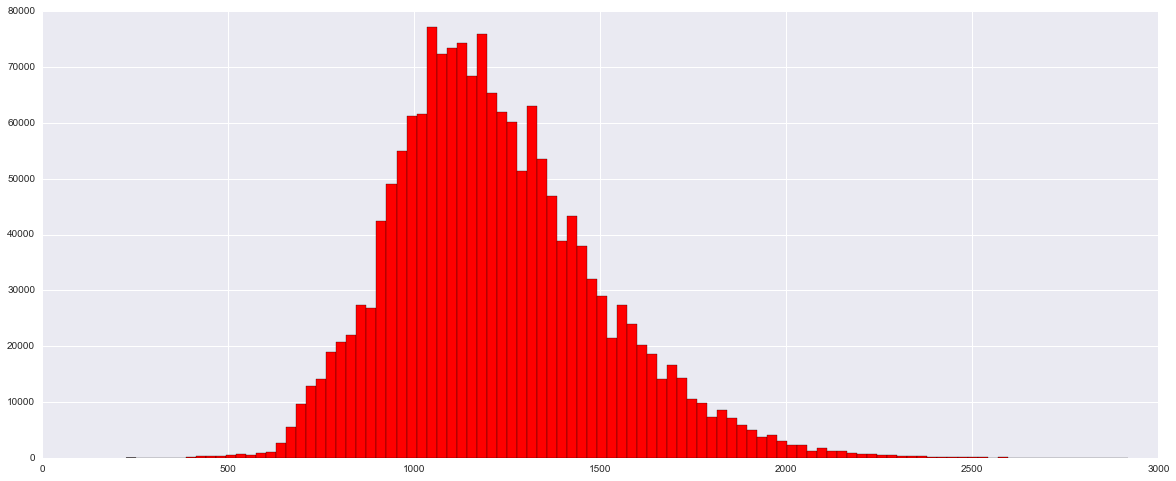

In [22]:
# Create a separate plot just to show the distribution of game length (removing lengthy outliers)
DataFrame["ReplayLength"][DataFrame.ReplayLength <= 3000].hist(figsize=(20, 8), color='red', bins=100)

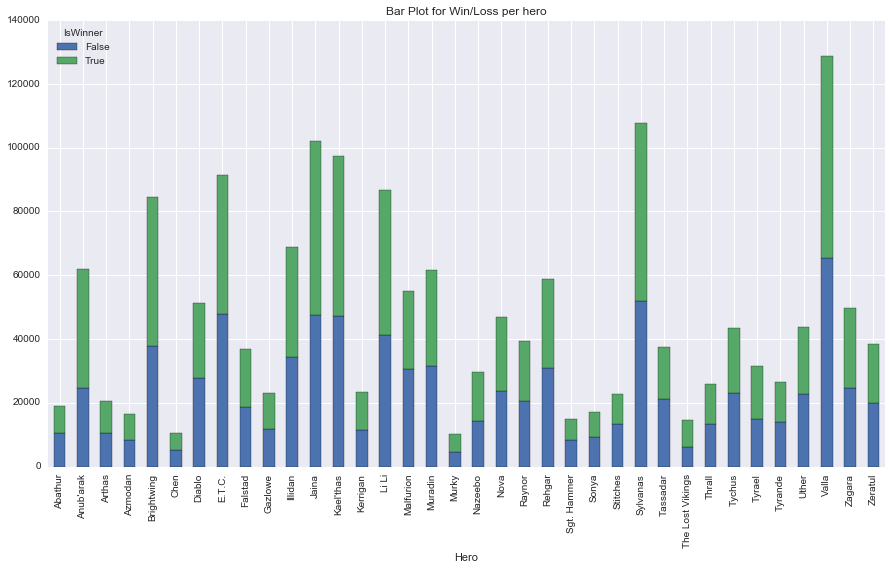

In [23]:
dfHero = DataFrame[["Hero", "IsWinner"]]
dfHero = dfHero.groupby(["Hero","IsWinner"])["Hero"].count().unstack('IsWinner')
dfHero.plot(kind="bar", stacked=True, figsize=(15,8), title="Bar Plot for Win/Loss per hero")

In [169]:
#Getting win rate in percentage per hero to plot in bar chart
dfGroup = DataFrame[["Hero", "IsWinner", "Group"]]

dfGroup = dfGroup.groupby(["Hero","IsWinner"]).count().unstack('IsWinner')

dfGroup.columns = ['Loss', 'Victory']
dfGroup.insert(0, 'WinRate', dfGroup.Victory/(dfGroup.Loss+dfGroup.Victory)*100)


# Defining classcodes to colour the chart below

# Assassin = 1, Warrior = 2, Support = 3, Specialist = 4
classcodes = [4, 2, 2, 4, 3, 2, 2, 2, 1, 4, 1, 1, 1, 1, 3, 3, 2, 4, 4, 1, 1, 3, 4, 2, 2, 4, 3, 4, 1, 1, 2, 3, 3, 1, 4, 1 ]

dfGroup['ClassCode'] = pd.Series(classcodes, index=dfGroup.index)

dfGroup.head()

,WinRate,Loss,Victory,ClassCode
Hero,,,,
Abathur,44.159771,10527,8325,4
Anub'arak,60.123523,24664,37187,2
Arthas,49.094823,10404,10034,2
Azmodan,50.340423,8242,8355,4
Brightwing,55.309735,37774,46750,3


In [188]:
# Test cell: trying to change colours of bars.


# for item in (len(dfGroup[dfGroup.columns[:0]]):
# dfGroup[dfGroup.columns[0]]

# dfGroup.shape


# x = np.arange(10)
# y = np.arange(10) * 0.1

# mask1 = y < 0.5
# mask2 = y >= 0.5

# plt.bar(x[assassinmask], y[assassinmask], color = 'red')
# plt.bar(x[wariormask], y[warriormask], color = 'blue')
# plt.bar(x[supportmask], y[supportmask], color = 'green')
# plt.bar(x[specialistmask], y[specialistmask], color = 'yellow')

# plt.show()

# barlist=plt.bar(['Hero'], ['WinRate'])
# barlist[0].set_color('r')
# plt.show()

# assassinmask = dfGroup['ClassCode'] == 1
# warriormask = dfGroup['ClassCode'] == 2
# supportmask = dfGroup['ClassCode'] == 3
# specialistmask = dfGroup['ClassCode'] == 4

# test = dfGroup['WinRate'].plot(kind="bar", figsize=(16,8), ylim=(40,62), color='red', title="Bar Plot for WinRate (%) per hero")

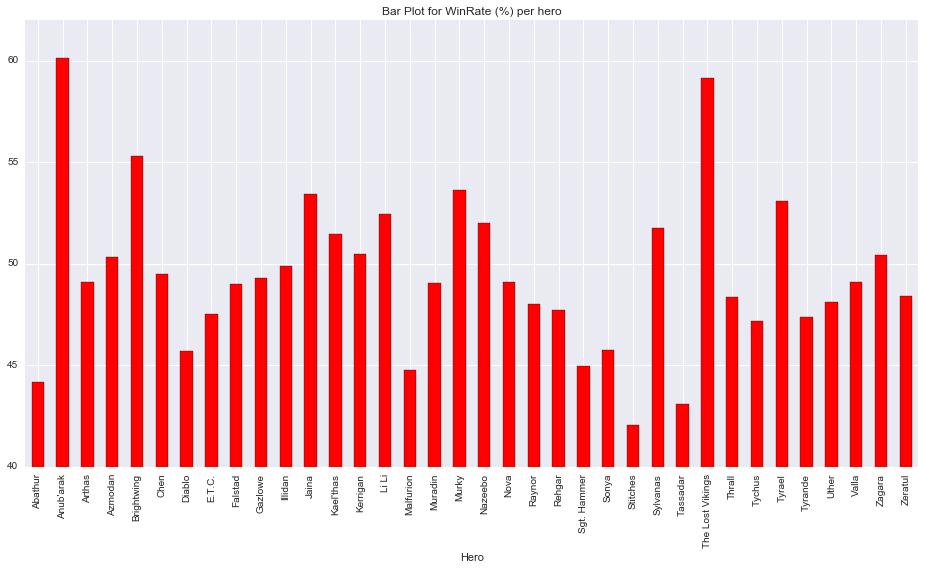

In [160]:
# DF_Map_Groups = pd.read_csv("HeroAndMap.csv")
# DF_Map_Groups.head()

# dfWinRate = pd.merge(dfGroup, DF_Map_Groups, left_on=["Group"], right_on=['Group'], how='left')

# if dfGroup.WIN.values > 50: 
#     y = 'blue'
# elif Group =='Support': 
#     y = 'green'
# elif Group == 'Assassin': 
#     y = 'red'
# elif Group == 'Warrior': 
#     y = 'yellow'
# else:
#     y= 'red'

# #DF_Replay[DF_Replay['GameMode'] == 4]
    

dfGroup['WinRate'].plot(kind="bar", figsize=(16,8), ylim=(40,62), color='red', title="Bar Plot for WinRate (%) per hero")

#  <u> Observations </u>
According to the graph above we can identify that the Heroes which are played the most are:  
- *Valla*   (Assassin) 
- *Sylvanas*    (Specialist)
- *Jaina*  (Assassin)
- *Kael'Thas*  (Assassin)
- *ETC*    (Warrior)

## Creating "Team Composition" feature from existing data

As mentioned above, this is one of the main features we wish to look at
- We begin by sorting our dataframe based on "ReplayID"
- With that in place, each record is then sorted by "IsWinner"
- This results in 10 entries for the same game being grouped together, where the first 5 are the winning team, and the second 5 are the losing team

In [26]:
DataFrame.sort_values(["ReplayID","IsWinner"],axis=0, inplace=True, ascending=[True, False])

In [27]:
DataFrame.head()

,ReplayID,Map,ReplayLength,Hero,HeroLevel,IsWinner,MMRbefore,Group
14251,23812009,Garden of Terror,814.0,E.T.C.,8,True,3341.0,Warrior
14252,23812009,Garden of Terror,814.0,Rehgar,10,True,3008.0,Support
14253,23812009,Garden of Terror,814.0,Raynor,10,True,2850.0,Assassin
14254,23812009,Garden of Terror,814.0,Jaina,8,True,2835.0,Assassin
14255,23812009,Garden of Terror,814.0,Sylvanas,16,True,2648.0,Specialist


We want to extract two lists from each game: one from the winning team and one from the losing team

Each list will record the classes of characters present on that team. For example:

    Winner = ["Assassin", "Support", "Support", "Specialist", "Warrior"]

This list will then be sorted alphabetically and checked against a list of class compositions recorded so far. If that particular configuration is not present, it will be added. This allows us to see the unique team compositions present in our dataset.

In [28]:
df_classes = DataFrame[["IsWinner", "ReplayID", "Group", "MMRbefore"]]
df_classes.shape

(1697780, 4)

In [29]:
df_classes.head()

,IsWinner,ReplayID,Group,MMRbefore
14251,True,23812009,Warrior,3341.0
14252,True,23812009,Support,3008.0
14253,True,23812009,Assassin,2850.0
14254,True,23812009,Assassin,2835.0
14255,True,23812009,Specialist,2648.0


## Note
**This cell may take a while to execute**

In [30]:
# Initialise lists to keep track of the group of 5 classes (a.k.a. Team Composition) played in any given game
# Initialise another list to keep track of each of these lists of 5 classes
# Similar thing with MMR (a.k.a. Player Rating), but divide by 5 to get average player rating on the team
# Initialise a counter to 0, and cycle through every row in the dataframe
# The dataframe is sorted by ReplayID, so every 10 rows corresponds to 1 game
# Once counter reaches 10, reset the appropriate lists after adding their values to the larger lists

comp_win = []
comp_lose = []
composition_list = []
mmr_win = 0
mmr_lose = 0
mmr_list = []
counter = 0
for x in range(len(df_classes)):
    if df_classes.IsWinner.iloc[x] == True:
        comp_win.append(df_classes.Group.iloc[x])
        mmr_win += df_classes.MMRbefore.iloc[x]
    else:
        comp_lose.append(df_classes.Group.iloc[x])
        mmr_lose += df_classes.MMRbefore.iloc[x]
    counter += 1
    if counter == 10: # All values for a single game have been read, so now add them to lists
        comp_win.sort()
        comp_lose.sort()
        composition_list.append(comp_win)
        composition_list.append(comp_lose)
        comp_win = []
        comp_lose = []
        mmr_list.append(mmr_win//5)
        mmr_list.append(mmr_lose//5)
        mmr_win = 0
        mmr_lose = 0
        counter = 0 # Restart counter to represent next game
        
print("Finished")  

Finished


In [31]:
# From the entire list of all Team Compositions played, create a list of only the unique ones
# This can then be used to create dummies that will be used to convey what Team Composition a particular team played
# Necessary for our logisitic regression

unique_comps = []
for item in composition_list:
    if item not in unique_comps:
        unique_comps.append(item)
        
# Check that every composition conisists of 5 Classes
for j in unique_comps:
    if len(j) != 5:
        print("Error")

At this point, every player record has an associated "Team Composition" showing the 5 classes that were chosen on their team that game.

This is in the form of a list. E.g. ["Assassin", "Support", "Support", "Specialist", "Warrior"]

As we will be creating a new feature based on this information, we attempt to increase readability by converting these lists to a string of letters, each representing a particular class

In [32]:
# For compositions to be easily readable, we will convert every list of 5 classes to a string representation
# A = Assassin
# S = Support
# Sp = Specialist
# W = Warrior
# For example, the string AASpWW would represent ["Assassin", "Assassin", "Specialist", "Warrior", "Warrior"]
str_comps = []
for composition in composition_list:
    string_rep = "" # String to keep track of class initials
    for character_class in composition:
        if character_class == "Specialist": # 2 classes begin with "S", so represent Specialist as "Sp"
            string_rep += character_class[0:2]
        else:
            string_rep += character_class[0]
    str_comps.append(string_rep) # Add the composition to the list
    
# Check that formatting is as expected
print(str_comps[0:5])

['AASpSW', 'AASpSW', 'AAASW', 'ASpSpSW', 'AASpSW']


In [33]:
# Create a list that can be used as a pandas Series to add as a column to our dataframe
# The ratings calculated on a per-team basis, but at the moment we still have one row per player
# Therefore, create 5 of each entry
col_rating = []
for i in mmr_list:
    for j in range(5):
        col_rating.append(i)

In [34]:
# Same as the previous cell, but for team composition
col_comp = []
for i in str_comps:
    for j in range(5):
        col_comp.append(i)

In [35]:
# Add these columns to the dataframe
DataFrame['Composition'] = pd.Series(col_comp, index=DataFrame.index)
DataFrame['Rating'] = pd.Series(col_rating, index=DataFrame.index)

In [36]:
DataFrame.head(20)

,ReplayID,Map,ReplayLength,Hero,HeroLevel,IsWinner,MMRbefore,Group,Composition,Rating
14251,23812009,Garden of Terror,814.0,E.T.C.,8,True,3341.0,Warrior,AASpSW,2936.0
14252,23812009,Garden of Terror,814.0,Rehgar,10,True,3008.0,Support,AASpSW,2936.0
14253,23812009,Garden of Terror,814.0,Raynor,10,True,2850.0,Assassin,AASpSW,2936.0
14254,23812009,Garden of Terror,814.0,Jaina,8,True,2835.0,Assassin,AASpSW,2936.0
14255,23812009,Garden of Terror,814.0,Sylvanas,16,True,2648.0,Specialist,AASpSW,2936.0
14250,23812009,Garden of Terror,814.0,Uther,7,False,2336.0,Support,AASpSW,2191.0
14256,23812009,Garden of Terror,814.0,Valla,9,False,2311.0,Assassin,AASpSW,2191.0
14257,23812009,Garden of Terror,814.0,Diablo,9,False,2971.0,Warrior,AASpSW,2191.0
14258,23812009,Garden of Terror,814.0,Sgt. Hammer,10,False,804.0,Specialist,AASpSW,2191.0
14259,23812009,Garden of Terror,814.0,Falstad,7,False,2535.0,Assassin,AASpSW,2191.0


Finally, we remove duplicated entries so we are left with 2 rows for each game; one for the winning team, and one for the losing team.

These records will also indicate the composition played by the team and the average player rating.

In [37]:
# Create a new dataframe that is to be modified to contain only a single record per team (i.e. 2 entries per game)
DF_Teams = DataFrame[["ReplayID", "Map", "ReplayLength", "IsWinner", "Composition", "Rating"]]

In [38]:
# Perform drop on rows that do not have unqiue values for the pair "ReplayID" and "IsWinner"
DF_Teams.drop_duplicates(["ReplayID", "IsWinner"], inplace=True)
DF_Teams.head(20)

C:\Users\brendan\Anaconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


,ReplayID,Map,ReplayLength,IsWinner,Composition,Rating
14251,23812009,Garden of Terror,814.0,True,AASpSW,2936.0
14250,23812009,Garden of Terror,814.0,False,AASpSW,2191.0
152140,23888167,Sky Temple,1022.0,True,AAASW,2436.0
152141,23888167,Sky Temple,1022.0,False,ASpSpSW,2280.0
174490,23908266,Blackheart's Bay,1671.0,True,AASpSW,2283.0
174491,23908266,Blackheart's Bay,1671.0,False,AAAAW,2161.0
163500,23908285,Tomb of the Spider Queen,810.0,True,AASpSW,2349.0
163501,23908285,Tomb of the Spider Queen,810.0,False,AASpSW,2292.0
168691,23908290,Sky Temple,1359.0,True,AASpSW,2252.0
168690,23908290,Sky Temple,1359.0,False,AASpSW,2504.0


In [39]:
# Write this to a csv file to be read as needed
DF_Teams.to_csv("Team_Info.csv")

In [40]:
DF_Teams = pd.read_csv("Team_Info.csv")

## Modeling Data

We now attempt to generate a model that can be used to predict the outcome of a game, given one team's composition and the average player rating on that team.

Our goal is to determine whether any particular combinations of character classes confer an advantage during the game, making a victory more likely.

From our initial analysis of the compositions in our dataset, we established 56 combinations of character classes that were played.

We will create dummies for each of these, and use a "1" to indicate that that was the composition played by the team, and a "0" to indicate that it was not.

This is needed to perform the logistic regression using scikitlearn, where categorical string values are not permitted.

In [41]:
# Drop the Unnamed index column
DF_Teams.drop("Unnamed: 0", inplace=True, axis=1)

# Create dummies for the Composition feature
dummy_comps = pd.get_dummies(DF_Teams["Composition"], prefix="COMP")

In [42]:
# Convert the True and False values of "IsWinner" to 1 or 0
# This allows them to be used in the logisitic regression without error
DF_Teams["IsWinner"] = DF_Teams["IsWinner"].astype(int)

# Create a dataframe that is just the "IsWinner", "Rating", and dummy values
model_df = pd.concat([DF_Teams[["IsWinner", "Rating"]], dummy_comps], axis=1)
model_df.shape

(339556, 58)

In [43]:
# Set up intercept column
intercept = pd.DataFrame({'Intercept': np.ones(len(DF_Teams))})

# For our X matrix, we want all of the dummy columns for Composition, the Rating, and the Intercept
X = pd.concat([intercept, model_df.drop("IsWinner", axis=1)], axis=1)

# For our y vector, we just want the "IsWinner" feature (target feature)
y = model_df.IsWinner
print("Descriptive features:\n", X)
print("\nTarget feature:\n", y)

Descriptive features:
         Intercept  Rating  COMP_AAAAA  COMP_AAAAS  COMP_AAAASp  COMP_AAAAW  \
0             1.0  2936.0         0.0         0.0          0.0         0.0   
1             1.0  2191.0         0.0         0.0          0.0         0.0   
2             1.0  2436.0         0.0         0.0          0.0         0.0   
3             1.0  2280.0         0.0         0.0          0.0         0.0   
4             1.0  2283.0         0.0         0.0          0.0         0.0   
5             1.0  2161.0         0.0         0.0          0.0         1.0   
6             1.0  2349.0         0.0         0.0          0.0         0.0   
7             1.0  2292.0         0.0         0.0          0.0         0.0   
8             1.0  2252.0         0.0         0.0          0.0         0.0   
9             1.0  2504.0         0.0         0.0          0.0         0.0   
10            1.0  2255.0         0.0         0.0          0.0         0.0   
11            1.0  2352.0         0.0    

In [44]:
# Train our model using just the "Rating" feature
model = LogisticRegression().fit(X[["Intercept", "Rating"]], y)
print("Coefficients: \n", model.coef_)

Coefficients: 
 [[ -1.42680516e-01   1.33561116e-04]]


In [45]:
# Get the probabilities that, given a particular team rating, the result will be a win or a loss
model.predict_proba(X[["Intercept", "Rating"]])

array([[ 0.47333173,  0.52666827],
       [ 0.49818216,  0.50181784],
       [ 0.49000287,  0.50999713],
       ..., 
       [ 0.50729718,  0.49270282],
       [ 0.52240848,  0.47759152],
       [ 0.52900218,  0.47099782]])

In [46]:
# Based on this model, attempt to correctly predict the "IsWinner" feature based on in-sample data
predictions = model.predict(X[["Intercept", "Rating"]])
print("Predictions: ", predictions)

Predictions:  [1 1 1 ..., 0 0 0]


In [47]:
# Get the score, indicating the percentage of times that our model correctly predits the outcome
model.score(X[["Intercept", "Rating"]], y)

0.51437759898220026

In [48]:
# Get more detailed information
print("Accuracy: ", metrics.accuracy_score(y, predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y, predictions))
print("Classification report:\n ", metrics.classification_report(y, predictions))

Accuracy:  0.514377598982
Confusion matrix: 
 [[91928 77850]
 [87046 82732]]
Classification report:
               precision    recall  f1-score   support

          0       0.51      0.54      0.53    169778
          1       0.52      0.49      0.50    169778

avg / total       0.51      0.51      0.51    339556



## Normalise continuous feature "Rating"

"Rating" is a continuous feature with no set range.

Here we normalise it so that the lowest value is represented as -1 and the highest value is represented as +1

Everything in between is adjusted accordingly.

In [49]:
# Create a dataframe for just the continuous descriptive features that we are interested in -> "Rating"
df_cont = model_df["Rating"]
df_norm = (df_cont - df_cont.min()) / (df_cont.max() - df_cont.min())
df_norm = df_norm * 2 - 1
df_norm.head()

0    0.354822
1   -0.029397
2    0.096957
3    0.016503
4    0.018051
Name: Rating, dtype: float64

In [50]:
# Create dataframe as before, with intercept, but replacing the rating values
no_rating = model_df.drop("Rating", axis=1)
DF_Normalised = pd.concat([intercept, df_norm, no_rating], axis=1)
DF_Normalised.head(10)

,Intercept,Rating,IsWinner,COMP_AAAAA,COMP_AAAAS,COMP_AAAASp,COMP_AAAAW,COMP_AAASS,COMP_AAASW,COMP_AAASpS,...,COMP_SpSpSWW,COMP_SpSpSpSS,COMP_SpSpSpSW,COMP_SpSpSpSpS,COMP_SpSpSpSpSp,COMP_SpSpSpSpW,COMP_SpSpSpWW,COMP_SpSpWWW,COMP_SpWWWW,COMP_WWWWW
0,1.0,0.354822,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.029397,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.096957,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.016503,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.018051,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,-0.044868,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.052089,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.022692,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.002063,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.132027,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Retraining model using normalised continuous features, and additional features
We train the model again using the normalised values for the "Rating" feature, and now also include the "Team Composition" features, represented in binary form

In [51]:
# Set up X and y again
# This time include the team composition features
X2 = DF_Normalised.drop("IsWinner", axis=1)
y2 = DF_Normalised.IsWinner

logreg = LogisticRegression().fit(X2, y2)
print(logreg.coef_)

[[-0.10061463  0.27389729  0.19499133  0.10140699 -0.07271392 -0.16761046
   0.07554122  0.21859847  0.22764525 -0.13738828 -0.15455052 -0.22625029
  -0.39843101  0.04626055  0.16260093  0.22083051  0.2719737   0.26821817
   0.06523536  0.03166761 -0.1693791  -0.25694817 -0.61358927 -0.35259451
  -0.12081571 -0.19896601  0.18421332  0.08592093  0.21171417  0.14531459
   0.31932378  0.38368715  0.21122919  0.03118454  0.04092007 -0.38414861
  -0.11550378  0.04885865 -0.20427785 -0.28781349 -0.13745584 -0.89184146
   0.4312037  -0.33005983 -0.27650014 -0.41695496 -0.37525699  0.09992686
   0.10637042 -0.06805256  0.34402555 -0.05321501  0.68899999  1.0784264
  -0.30273875  1.02350467 -0.76487434  0.05752217]]


In [52]:
# Run predictions again
predictions2 = logreg.predict(X2)
print("Predictions: ", predictions2)

Predictions:  [1 1 1 ..., 1 0 0]


In [53]:
# Print information on results
print("Accuracy: ", metrics.accuracy_score(DF_Normalised['IsWinner'], predictions2))
print("Confusion matrix: \n", metrics.confusion_matrix(DF_Normalised['IsWinner'], predictions2))
print("Classification report:\n ", metrics.classification_report(DF_Normalised['IsWinner'], predictions2))

Accuracy:  0.524749967605
Confusion matrix: 
 [[81872 87906]
 [73468 96310]]
Classification report:
               precision    recall  f1-score   support

          0       0.53      0.48      0.50    169778
          1       0.52      0.57      0.54    169778

avg / total       0.52      0.52      0.52    339556



While the predictive power of the model still seems quite low, there is a minor improvement to be noted when using more than just the "Rating" feature for our predictions

## Train Test Split - Model evaluation with out-of-sample data

In [54]:
# Split our data 70:30 (training:test)
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3)

In [55]:
# Train our model on the training set
logreg_train = LogisticRegression().fit(X_train, y_train)
print(logreg_train.coef_)

[[-0.08675913  0.26217809 -0.24337211  0.06241912 -0.18582703 -0.22949548
   0.05056966  0.19870788  0.14675364 -0.18242945 -0.19143121 -0.23641141
  -0.22812245  0.02468408  0.13298274  0.22703794  0.23941725  0.28361423
   0.12766556 -0.04491981 -0.20833865 -0.06292166 -0.62205784 -0.43656741
  -0.16564998 -0.35232101  0.22257382  0.06291092  0.17644747  0.18591214
   0.29569567  0.24154576  0.13374257 -0.07534243  0.06323445 -0.2104981
   0.04594781  0.03718567  0.04067508 -0.13173069 -0.14425619 -0.94647216
   0.         -0.23513066 -0.307416   -0.27781331 -0.18838325  0.02329599
  -0.03431352  0.25931516  0.26064486 -0.18169006  0.77781532  1.01816896
  -0.13486489  1.00926529 -0.60308015  0.42586872]]


In [56]:
# Print the predicted probabilities for each outcome of a game
print(logreg_train.predict_proba(X_test))

[[ 0.51017415  0.48982585]
 [ 0.49511993  0.50488007]
 [ 0.46835614  0.53164386]
 ..., 
 [ 0.55817237  0.44182763]
 [ 0.47641029  0.52358971]
 [ 0.48825987  0.51174013]]


In [79]:
# Estimate the "IsWinner" category that each row in the test data will fall into
# 1 => Victory
# 0 => Loss
predicted = logreg_train.predict(X_test)
print(predicted)

[0 1 1 ..., 0 1 1]


In [58]:
# Print model score
print(metrics.accuracy_score(y_test, predicted))

0.525371317502


In [59]:
# Further evaluation of the model using 3-fold cross validation
scores = cross_val_score(LogisticRegression(), X2, y2, scoring='accuracy', cv=3)
print(scores)
print(scores.mean())

[ 0.52235259  0.52517979  0.52332485]
0.5236190773


# Remarks

After training and retraining the model and examining its predictive power on in-sample versus out-of-sample data, we still achieve a final accuracy rating of roughly 52%.

This indicates that our model, given the information of "Team Composition" and "Rating", will correctly predict the outcome of a game just over half of the time.

Given that there are only 2 possible outcomes to every game (win or lose), this indicates that our model is not very strong.

It is possible that a stronger predictive model may be generated given additional data on each of the individual players, and using this in combination with what we have created up to this point.

## Beginning looking at maps

In [60]:
DataFrame.shape

(1697780, 10)

In [61]:
DataFrame[DataFrame.Map == 'Haunted Mines'].count()
# DataFrame[DataFrame.Map == "Sky Temple"].count()

ReplayID        243380
Map             243380
ReplayLength    243380
Hero            243380
HeroLevel       243380
IsWinner        243380
MMRbefore       243380
Group           243380
Composition     243380
Rating          243380
dtype: int64

In [62]:
DataFrame.Map.unique()

array(['Garden of Terror', 'Sky Temple', "Blackheart's Bay",
       'Tomb of the Spider Queen', 'Haunted Mines', 'Dragon Shire',
       'Cursed Hollow'], dtype=object)

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Garden of Terror Map

In [64]:
GardenTerror = DataFrame[DataFrame['Map'] == 'Garden of Terror']
GardenTerror.shape

(242730, 10)

In [65]:
GardenTerror.ReplayLength.shape

(242730,)

In [66]:
# Prepare an intercept term that adds a 1 to each example.
# Scikit-learn does not use an intercept by default.
intercept = pd.DataFrame({'Intercept': np.ones(len(GardenTerror))})
intercept.head()

,Intercept
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [67]:
print(GardenTerror.shape)
GardenTerror = GardenTerror.iloc[:5000]
print(GardenTerror.shape)

# Prepare the descriptive features
X = pd.concat([intercept, GardenTerror[['IsWinner', 'Hero']]], axis=1)
y = GardenTerror.IsWinner
print("Descriptive features:\n", X)
print("\nTarget feature:\n", y)

(242730, 10)
(5000, 10)
Descriptive features:
         Intercept IsWinner         Hero
0             1.0      NaN          NaN
1             1.0      NaN          NaN
2             1.0      NaN          NaN
3             1.0      NaN          NaN
4             1.0      NaN          NaN
5             1.0      NaN          NaN
6             1.0      NaN          NaN
7             1.0      NaN          NaN
8             1.0      NaN          NaN
9             1.0      NaN          NaN
10            1.0     True       Diablo
11            1.0    False       Arthas
12            1.0    False    Malfurion
13            1.0    False    Kael'thas
14            1.0    False      Falstad
15            1.0     True      Zeratul
16            1.0     True        Li Li
17            1.0     True  Sgt. Hammer
18            1.0     True       Tychus
19            1.0    False        Valla
20            1.0    False    Anub'arak
21            1.0     True    Kael'thas
22            1.0    False     Sy

In [68]:
#Create dummy values for Winner feature
GardenTerror_IsWinner = pd.get_dummies(GardenTerror['IsWinner'])

#GardenTerror_IsWinner.head()

Winner_new = pd.concat([GardenTerror, GardenTerror_IsWinner], axis=1)

Winner_new.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

Winner_new.head(10)

,ReplayID,Map,ReplayLength,Hero,HeroLevel,IsWinner,MMRbefore,Group,Composition,Rating,Loser,Winner
14251,23812009,Garden of Terror,814.0,E.T.C.,8,True,3341.0,Warrior,AASpSW,2936.0,0.0,1.0
14252,23812009,Garden of Terror,814.0,Rehgar,10,True,3008.0,Support,AASpSW,2936.0,0.0,1.0
14253,23812009,Garden of Terror,814.0,Raynor,10,True,2850.0,Assassin,AASpSW,2936.0,0.0,1.0
14254,23812009,Garden of Terror,814.0,Jaina,8,True,2835.0,Assassin,AASpSW,2936.0,0.0,1.0
14255,23812009,Garden of Terror,814.0,Sylvanas,16,True,2648.0,Specialist,AASpSW,2936.0,0.0,1.0
14250,23812009,Garden of Terror,814.0,Uther,7,False,2336.0,Support,AASpSW,2191.0,1.0,0.0
14256,23812009,Garden of Terror,814.0,Valla,9,False,2311.0,Assassin,AASpSW,2191.0,1.0,0.0
14257,23812009,Garden of Terror,814.0,Diablo,9,False,2971.0,Warrior,AASpSW,2191.0,1.0,0.0
14258,23812009,Garden of Terror,814.0,Sgt. Hammer,10,False,804.0,Specialist,AASpSW,2191.0,1.0,0.0
14259,23812009,Garden of Terror,814.0,Falstad,7,False,2535.0,Assassin,AASpSW,2191.0,1.0,0.0


In [69]:
#import the needed module
import statsmodels.formula.api as sm

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_new[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

Optimization terminated successfully.
         Current function value: 0.692423
         Iterations 3
Intercept   -0.269772
Rating       0.000122
dtype: float64


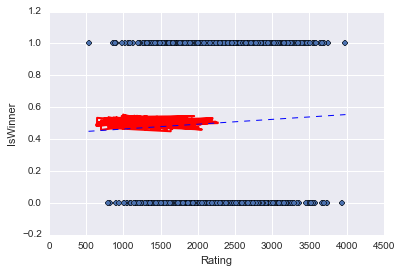

In [70]:
X_minmax = pd.DataFrame({'Rating': [Winner_new.Rating.min(), Winner_new.Rating.max()]})

predictions = logreg.predict(Winner_new)

# First, plot the observed data
Winner_new.plot(kind='scatter', x='Rating', y='IsWinner')

# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_new.ReplayLength, predictions, c='red', linewidth=2)

# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Sky Temple Map

Optimization terminated successfully.
         Current function value: 0.692016
         Iterations 3
Intercept   -0.344131
Rating       0.000152
dtype: float64


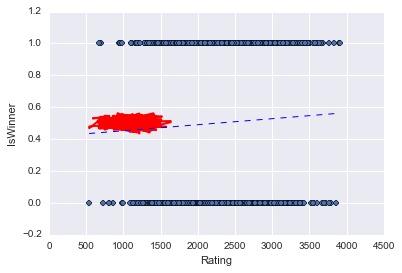

In [71]:
SkyTemple = DataFrame.loc[DataFrame['Map'] == 'Sky Temple']

intercept = pd.DataFrame({'Intercept': np.ones(len(SkyTemple))})
intercept.head()

SkyTemple = SkyTemple.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, SkyTemple[['IsWinner', 'Hero']]], axis=1)
y = SkyTemple.IsWinner

SkyTemple_IsWinner = pd.get_dummies(SkyTemple['IsWinner'])
Winner_Sky = pd.concat([SkyTemple, SkyTemple_IsWinner], axis=1)
Winner_Sky.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Sky[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Sky.Rating.min(), Winner_Sky.Rating.max()]})

predictions = logreg.predict(Winner_Sky)

# First, plot the observed data
Winner_Sky.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Sky.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Dragon Shire Map

Optimization terminated successfully.
         Current function value: 0.691720
         Iterations 4
Intercept   -0.384762
Rating       0.000172
dtype: float64


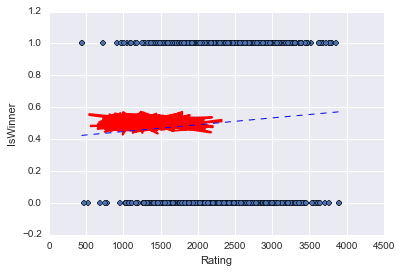

In [72]:
DragonShire = DataFrame.loc[DataFrame['Map'] == 'Dragon Shire']

intercept = pd.DataFrame({'Intercept': np.ones(len(DragonShire))})

DragonShire = DragonShire.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, DragonShire[['IsWinner', 'Hero']]], axis=1)
y = DragonShire.IsWinner

DragonShire_IsWinner = pd.get_dummies(DragonShire['IsWinner'])
Winner_Dragon = pd.concat([DragonShire, DragonShire_IsWinner], axis=1)
Winner_Dragon.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Dragon[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Dragon.Rating.min(), Winner_Dragon.Rating.max()]})

predictions = logreg.predict(Winner_Sky)

# First, plot the observed data
Winner_Dragon.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Dragon.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Blackheart's Bay Map

Optimization terminated successfully.
         Current function value: 0.692561
         Iterations 3
Intercept   -0.251046
Rating       0.000113
dtype: float64


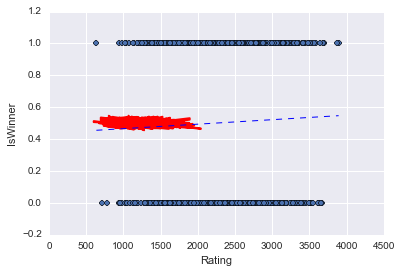

In [73]:
BlackheartsBay = DataFrame.loc[DataFrame['Map'] == "Blackheart's Bay"]

intercept = pd.DataFrame({'Intercept': np.ones(len(BlackheartsBay))})

BlackheartsBay = BlackheartsBay.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, BlackheartsBay[['IsWinner', 'Hero']]], axis=1)
y = BlackheartsBay.IsWinner

BlackheartsBay_IsWinner = pd.get_dummies(BlackheartsBay['IsWinner'])
Winner_Bay = pd.concat([BlackheartsBay, BlackheartsBay_IsWinner], axis=1)
Winner_Bay.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Bay[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Bay.Rating.min(), Winner_Bay.Rating.max()]})

predictions = logreg.predict(Winner_Bay)

# First, plot the observed data
Winner_Bay.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Bay.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Spider Queen Map

Optimization terminated successfully.
         Current function value: 0.692159
         Iterations 3
Intercept   -0.328888
Rating       0.000145
dtype: float64


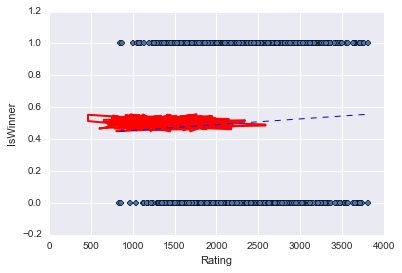

In [74]:
SpiderQueen = DataFrame.loc[DataFrame['Map'] == 'Tomb of the Spider Queen']

intercept = pd.DataFrame({'Intercept': np.ones(len(SpiderQueen))})

SpiderQueen = SpiderQueen.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, SpiderQueen[['IsWinner', 'Hero']]], axis=1)
y = SpiderQueen.IsWinner

SpiderQueen_IsWinner = pd.get_dummies(SpiderQueen['IsWinner'])
Winner_Spider = pd.concat([SpiderQueen, SpiderQueen_IsWinner], axis=1)
Winner_Spider.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Spider[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Spider.Rating.min(), Winner_Spider.Rating.max()]})

predictions = logreg.predict(Winner_Spider)

# First, plot the observed data
Winner_Spider.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Spider.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Cursed Hollow Map

Optimization terminated successfully.
         Current function value: 0.692082
         Iterations 3
Intercept   -0.344795
Rating       0.000155
dtype: float64


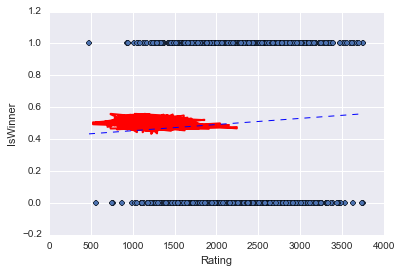

In [75]:
CursedHollow = DataFrame.loc[DataFrame['Map'] == 'Cursed Hollow']

intercept = pd.DataFrame({'Intercept': np.ones(len(CursedHollow))})

CursedHollow = CursedHollow.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, CursedHollow[['IsWinner', 'Hero']]], axis=1)
y = CursedHollow.IsWinner

CursedHollow_IsWinner = pd.get_dummies(CursedHollow['IsWinner'])
Winner_Hollow = pd.concat([CursedHollow, CursedHollow_IsWinner], axis=1)
Winner_Hollow.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Hollow[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Hollow.Rating.min(), Winner_Hollow.Rating.max()]})

predictions = logreg.predict(Winner_Hollow)

# First, plot the observed data
Winner_Hollow.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Hollow.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

# Haunted Mines Map

Optimization terminated successfully.
         Current function value: 0.692283
         Iterations 3
Intercept   -0.298705
Rating       0.000134
dtype: float64


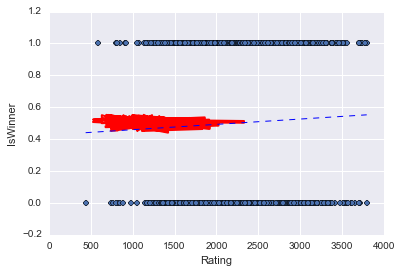

In [76]:
HauntedMines = DataFrame[DataFrame['Map'] == 'Haunted Mines']

intercept = pd.DataFrame({'Intercept': np.ones(len(HauntedMines))})

HauntedMines = HauntedMines.iloc[:5000]

# Prepare the descriptive features
X = pd.concat([intercept, HauntedMines[['IsWinner', 'Hero']]], axis=1)
y = HauntedMines.IsWinner

HauntedMines_IsWinner = pd.get_dummies(HauntedMines['IsWinner'])
Winner_Mines = pd.concat([HauntedMines, HauntedMines_IsWinner], axis=1)
Winner_Mines.columns = ['ReplayID', 'Map', 'ReplayLength', 'Hero', 'HeroLevel', 'IsWinner', 'MMRbefore', 'Group','Composition', 'Rating', 'Loser', 'Winner']

logreg = sm.logit(formula="Winner ~ Rating", data= Winner_Mines[['Winner', 'Rating']]).fit()

# Print the model weights/parameters
print(logreg.params)

X_minmax = pd.DataFrame({'Rating': [Winner_Mines.Rating.min(), Winner_Mines.Rating.max()]})

predictions = logreg.predict(Winner_Mines)

# First, plot the observed data
Winner_Mines.plot(kind='scatter', x='Rating', y='IsWinner')
# Next, plot the logistic regression estimation, in red.
plt.plot(Winner_Mines.ReplayLength, predictions, c='red', linewidth=2)
# Plot the linear decision surface estimated by logistic regression
plt.plot(X_minmax, logreg.predict(X_minmax), c='blue', linewidth=1, linestyle='dashed')

## 1. Determine the most played heroes in each category:
After looking at the most played 7 Heroes in the games across the data set, the results were as follows:
* Support  
Brightwing  
Lili
  
  
* Assassin  
Valla  
Jaina  
-Kael'Thas
  
  
* Warrior  
E.T.C

  
* Specialist  
Sylvanas

#### Now to compare with the top 7 heroes by win rate:
* Support  
Brightwing
  
  
* Assassin  
Jaina
  
  
* Warrior  
Anub'Arak  
Tyrael

  
* Specialist  
The Lost Vikings  
Sylvanas  
Murky


In the end only 3 out of the 7 most played heroes belong to the highest win-rate bracket, suggesting that popularity is not strongly linked to actual utility.

This leads to the need to understand team composition in order to see how they can be a predictor of the outcome of a game.

## 2. Identify the various team compositions played

## 3. Study the effect of team rating on the outcome of the game?

## 4. Does team composition affect the outcome of the game?

In [77]:
# unique_comps is a list containing every unique team composition played in our dataset
# composition_list is a list containing every team composition played, regardless of how many times
# We can cycle through the lists and count the number of times each composition was played
# From this we can determine the most popular selection of classes, and the least popular
most_played_value = 0
least_played_value = 9999
most_played_team = []
least_played_team = []

for i in unique_comps:
    if composition_list.count(i) > most_played_value:
        most_played_value = composition_list.count(i)
        most_played_team = i
    if composition_list.count(i) < least_played_value:
        least_played_value = composition_list.count(i)
        least_played_team = i
    print(i, "------", composition_list.count(i))

['Assassin', 'Assassin', 'Specialist', 'Support', 'Warrior'] ------ 147694
['Assassin', 'Assassin', 'Assassin', 'Support', 'Warrior'] ------ 52791
['Assassin', 'Specialist', 'Specialist', 'Support', 'Warrior'] ------ 35799
['Assassin', 'Assassin', 'Assassin', 'Assassin', 'Warrior'] ------ 335
['Assassin', 'Assassin', 'Support', 'Support', 'Warrior'] ------ 28503
['Assassin', 'Specialist', 'Support', 'Support', 'Warrior'] ------ 24066
['Assassin', 'Specialist', 'Support', 'Warrior', 'Warrior'] ------ 14962
['Assassin', 'Assassin', 'Support', 'Warrior', 'Warrior'] ------ 15747
['Assassin', 'Assassin', 'Assassin', 'Specialist', 'Support'] ------ 2075
['Specialist', 'Specialist', 'Support', 'Warrior', 'Warrior'] ------ 1066
['Assassin', 'Assassin', 'Specialist', 'Specialist', 'Support'] ------ 1781
['Specialist', 'Specialist', 'Support', 'Support', 'Warrior'] ------ 1468
['Assassin', 'Assassin', 'Assassin', 'Assassin', 'Support'] ------ 465
['Assassin', 'Support', 'Support', 'Warrior', 'Wa

In [78]:
# Information on most and least commonly played compositions
print("Most Played")
print(most_played_team,"played", most_played_value, "times")
print("\nLeast Played")
print(least_played_team,"played", least_played_value, "time(s).")

Most Played
['Assassin', 'Assassin', 'Specialist', 'Support', 'Warrior'] played 147694 times

Least Played
['Specialist', 'Support', 'Support', 'Support', 'Support'] played 1 time(s).
